In [1]:
import scanpy as sc
import anndata as ann
import scipy as sci
import pandas as pd
import os
import numpy as np
import seaborn as sns
import episcanpy.api as epi

/home/97212545/anaconda3/envs/scanpy/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
SCRNA_DIR = '../data/chen-2019/AdBrainCortex/rna/'
SCATAC_DIR = '../data/chen-2019/AdBrainCortex/atac/'
META_PATH = '../data/chen-2019/AdBrainCortex/AdBrainCortex.csv'

# MetaData

In [4]:
metadata = pd.read_csv(META_PATH, index_col=0)
metadata.head()

,Batch,Barcode,Ident
09A_CAGCCCCGCCTT,09A,CAGCCCCGCCTT,E3Rorb
09A_CGCCTACCATGA,09A,CGCCTACCATGA,E5Parm1
09A_GATGCGCGGCTA,09A,GATGCGCGGCTA,Ast
09A_GGTCCGAGTCCT,09A,GGTCCGAGTCCT,E4Il1rapl2
09A_TCTCCCGGCACC,09A,TCTCCCGGCACC,E5Parm1


# scRNA-seq Data

In [5]:
%%time
scrna = sc.read_10x_mtx(SCRNA_DIR, var_names='gene_symbols', cache=True)
scrna.obs = metadata
scrna

CPU times: user 640 ms, sys: 72 ms, total: 712 ms
Wall time: 709 ms


AnnData object with n_obs × n_vars = 10309 × 33160
    obs: 'Batch', 'Barcode', 'Ident'
    var: 'gene_ids'

In [6]:
scrna.var.head()

,gene_ids
0610005C13Rik,0610005C13Rik
0610007P14Rik,0610007P14Rik
0610009B22Rik,0610009B22Rik
0610009E02Rik,0610009E02Rik
0610009L18Rik,0610009L18Rik


## Data Cleaning

In [7]:
scrna.obs = scrna.obs.rename(columns={'Ident': 'cell_type'})

In [8]:
scrna.obs['Batch'] = scrna.obs['Batch'].astype('category')
scrna.obs['cell_type'] = scrna.obs['cell_type'].astype('category')

In [9]:
scrna.var = scrna.var.rename(columns={'gene_ids': 'gene_symbols'})

# Quality Control

In [10]:
scrna.var_names_make_unique()

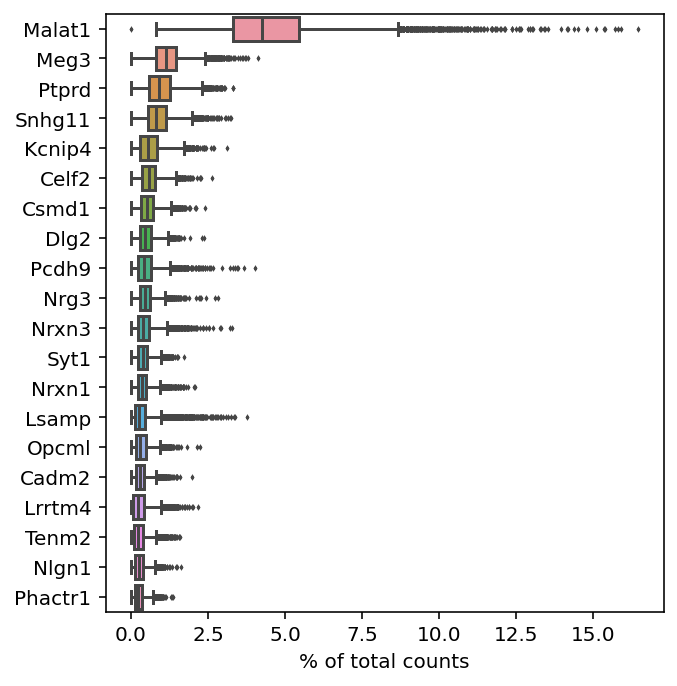

In [11]:
sc.pl.highest_expr_genes(scrna, n_top=20)

In [12]:
sc.pp.filter_cells(scrna, min_genes=100)
sc.pp.filter_genes(scrna, min_cells=3)
scrna

AnnData object with n_obs × n_vars = 10309 × 25403
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes'
    var: 'gene_symbols', 'n_cells'

## Qalculate QC metrics including Mitochondrial genes

In [13]:
scrna.var['mt'] = scrna.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(scrna, qc_vars=['mt'], percent_top=None, inplace=True)
scrna

AnnData object with n_obs × n_vars = 10309 × 25403
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

... storing 'Barcode' as categorical


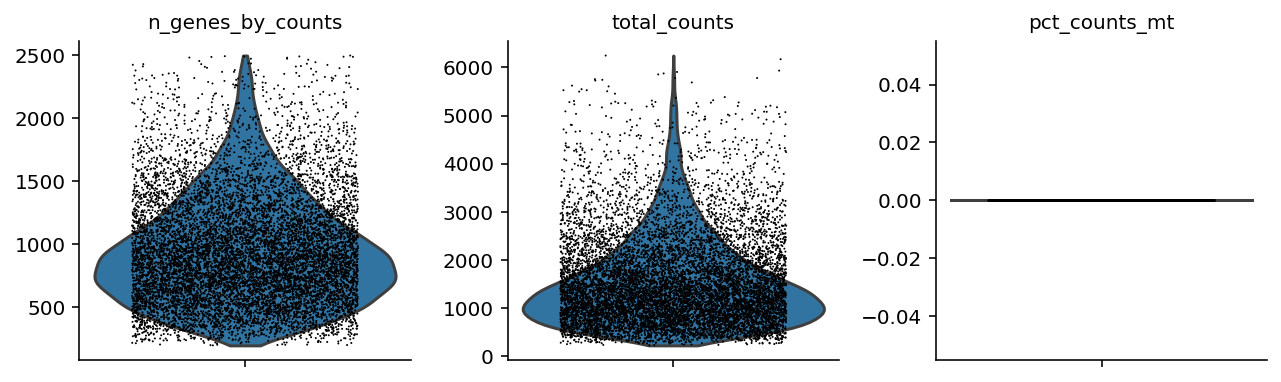

In [14]:
sc.pl.violin(scrna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.3, multi_panel=True)

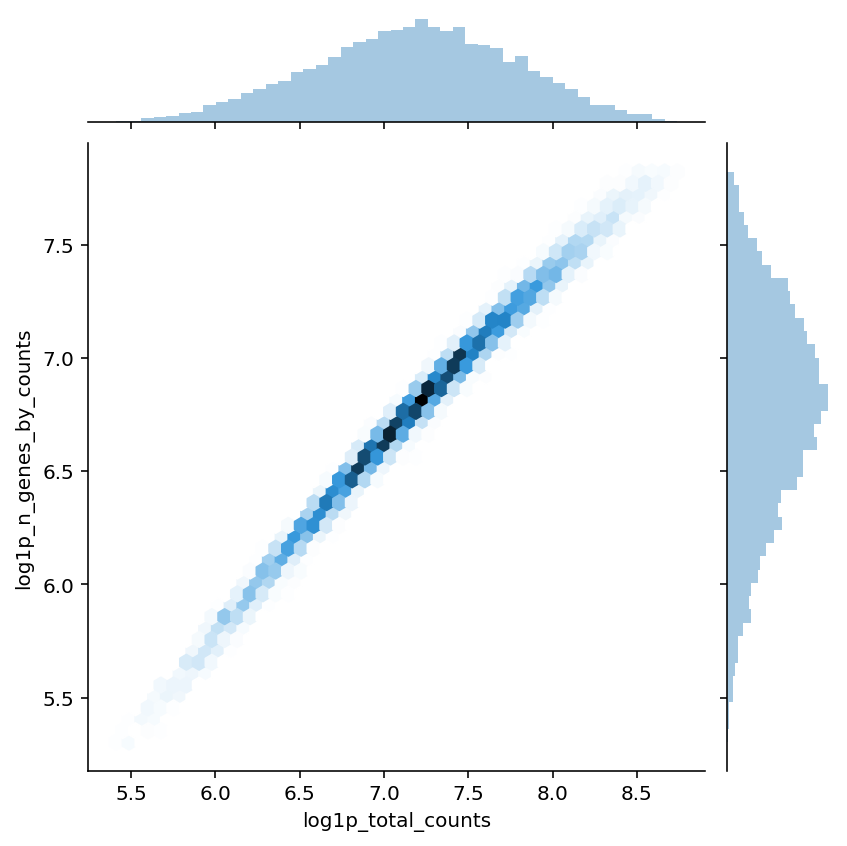

In [15]:
sns.jointplot("log1p_total_counts", "log1p_n_genes_by_counts", data=scrna.obs, kind='hex');

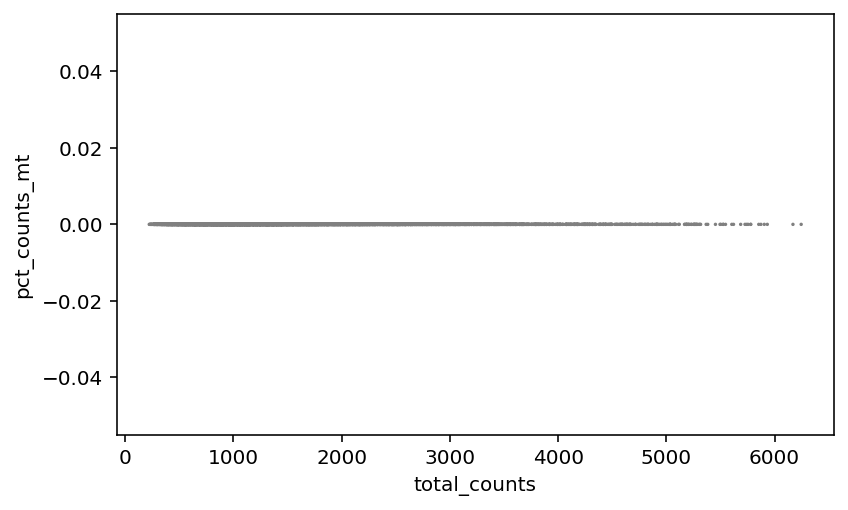

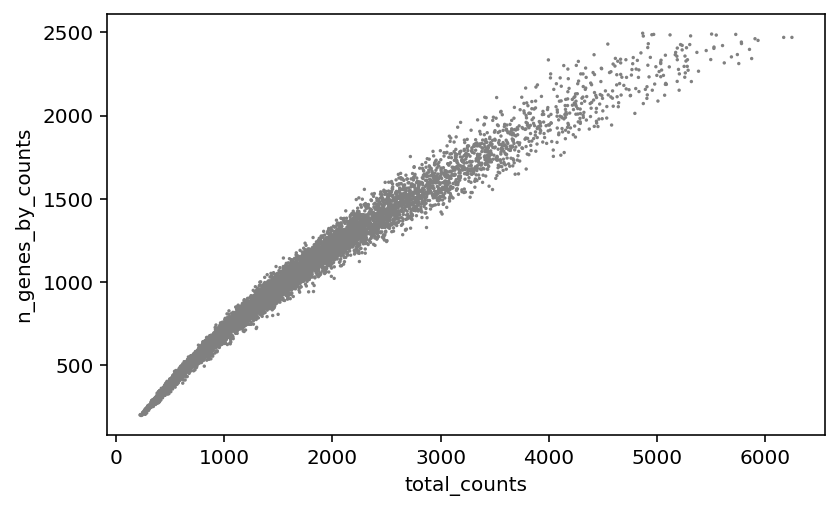

In [16]:
sc.pl.scatter(scrna, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(scrna, x='total_counts', y='n_genes_by_counts')

No mitochondrial samples! Good! 
Filter out samples with highest number of genes:

In [17]:
scrna = scrna[scrna.obs.n_genes_by_counts < 2200, :]
scrna

View of AnnData object with n_obs × n_vars = 10200 × 25403
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Normalization

In [18]:
sc.pp.normalize_total(scrna, target_sum=1e4)
sc.pp.log1p(scrna)

## Filtering Highly Variable Genes

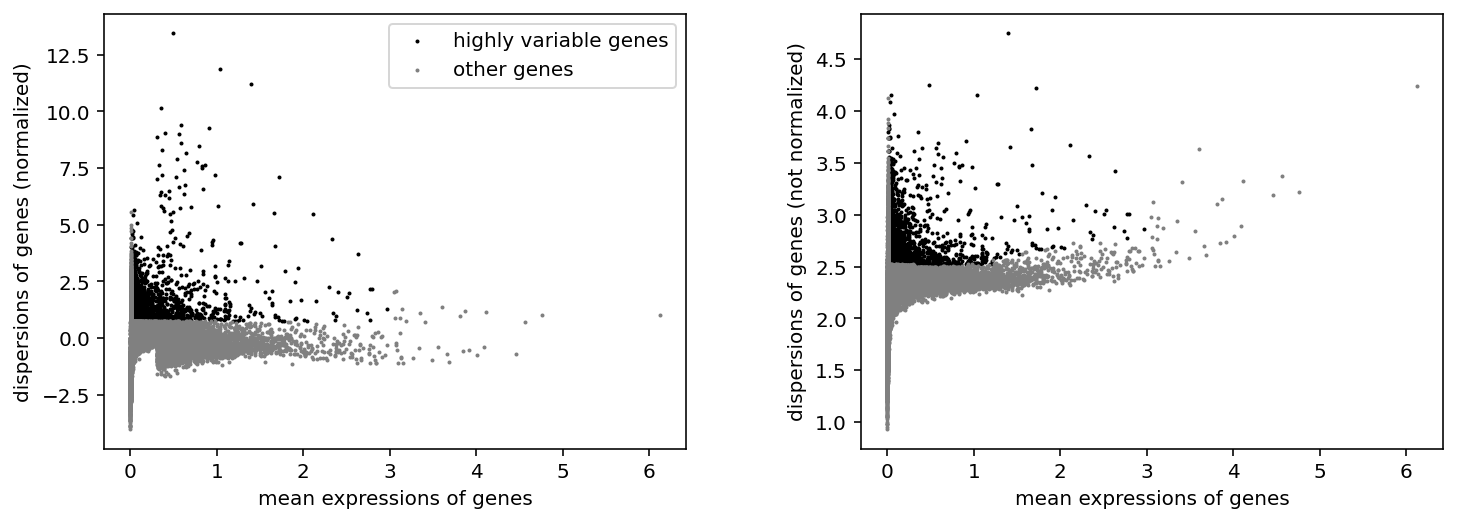

In [19]:
sc.pp.highly_variable_genes(scrna, min_mean=0.0125, max_mean=3, min_disp=0.75)
sc.pl.highly_variable_genes(scrna)

In [20]:
scrna = scrna[:, scrna.var.highly_variable]
scrna

View of AnnData object with n_obs × n_vars = 10200 × 2695
    obs: 'Batch', 'Barcode', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_symbols', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Visualization

### Running UMAP

In [25]:
sc.pp.neighbors(scrna, random_state=42)
sc.tl.umap(scrna, random_state=42)

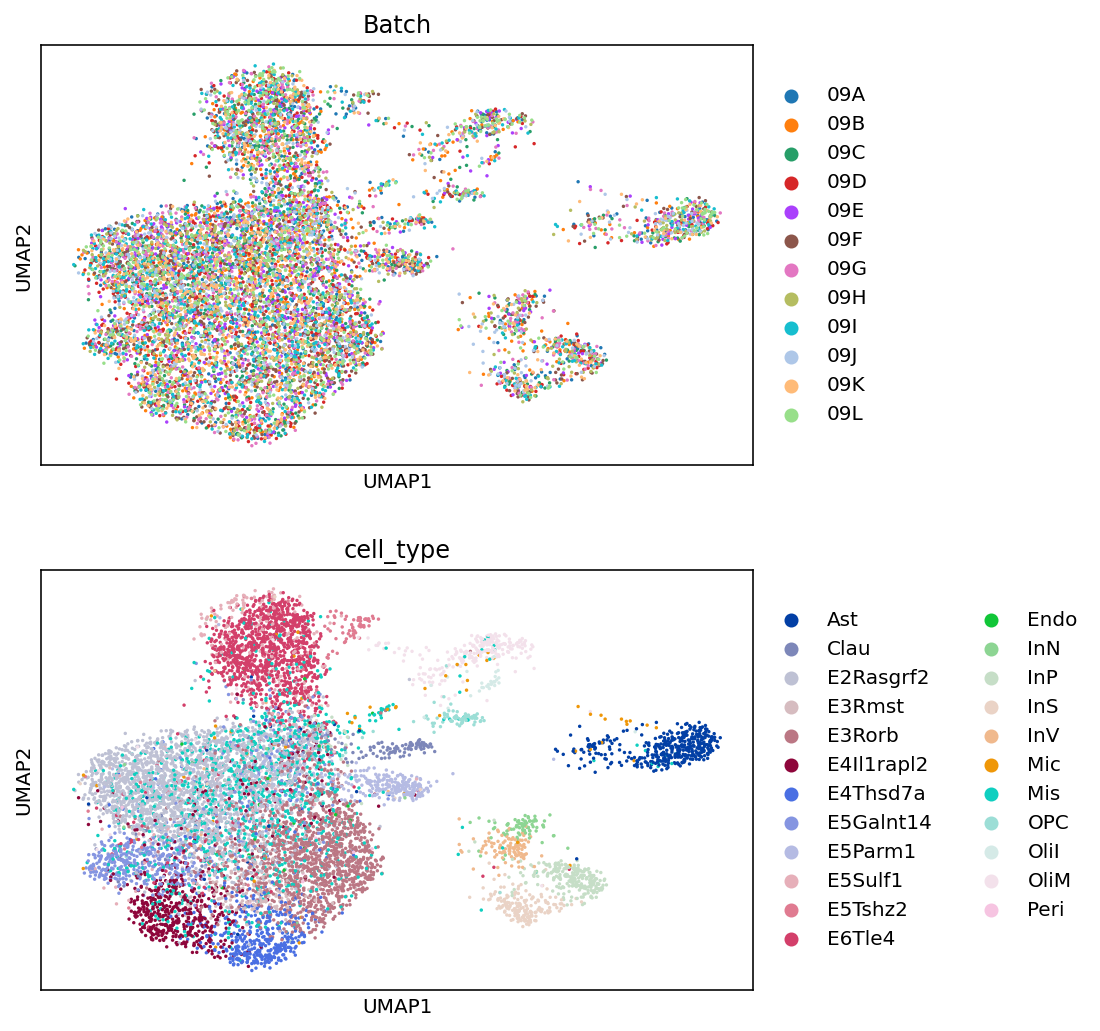

In [26]:
sc.pl.umap(scrna, color=['Batch', 'cell_type'], ncols=1)

---
# scATAC-seq Data

In [44]:
%%time
scatac = sc.read_10x_mtx(SCATAC_DIR, var_names='gene_symbols', cache=True)
scatac.obs = metadata
scatac

CPU times: user 1.97 s, sys: 168 ms, total: 2.14 s
Wall time: 2.13 s


AnnData object with n_obs × n_vars = 10309 × 244544
    obs: 'Batch', 'Barcode', 'Ident'
    var: 'gene_ids'

In [45]:
scatac.var.head()

,gene_ids
chr1:3005833-3005982,chr1:3005833-3005982
chr1:3094772-3095489,chr1:3094772-3095489
chr1:3119556-3120739,chr1:3119556-3120739
chr1:3121334-3121696,chr1:3121334-3121696
chr1:3134637-3135032,chr1:3134637-3135032


## Data Cleaning

In [46]:
scatac.obs = scatac.obs.rename(columns={'Ident': 'cell_type'})

In [47]:
scatac.obs['Batch'] = scatac.obs['Batch'].astype('category')
scatac.obs['cell_type'] = scatac.obs['cell_type'].astype('category')

## Binarization

In [48]:
%time scatac = epi.pp.binarize(scatac, copy=True)
scatac

CPU times: user 2 s, sys: 256 ms, total: 2.26 s
Wall time: 2.26 s


AnnData object with n_obs × n_vars = 10309 × 244544
    obs: 'Batch', 'Barcode', 'cell_type'
    var: 'gene_ids'

## Quality Control

In [49]:
epi.pp.filter_features(scatac, min_cells=1)
scatac

AnnData object with n_obs × n_vars = 10309 × 244538
    obs: 'Batch', 'Barcode', 'cell_type'
    var: 'gene_ids', 'n_cells'

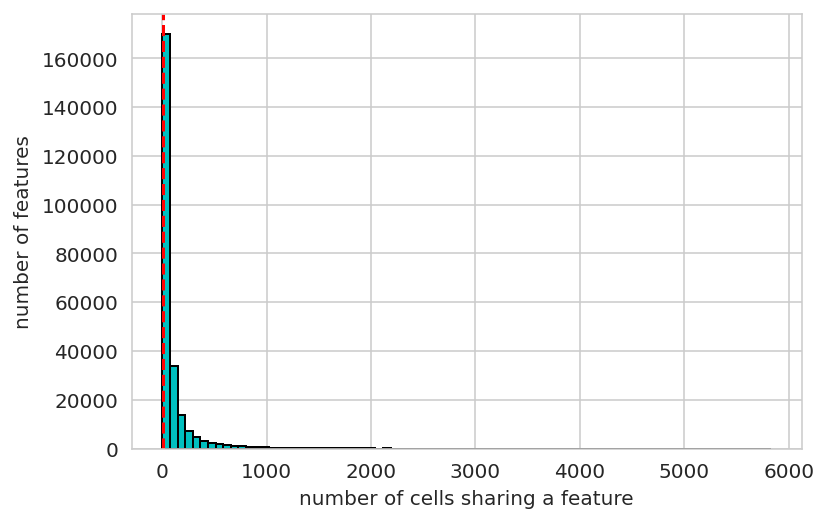

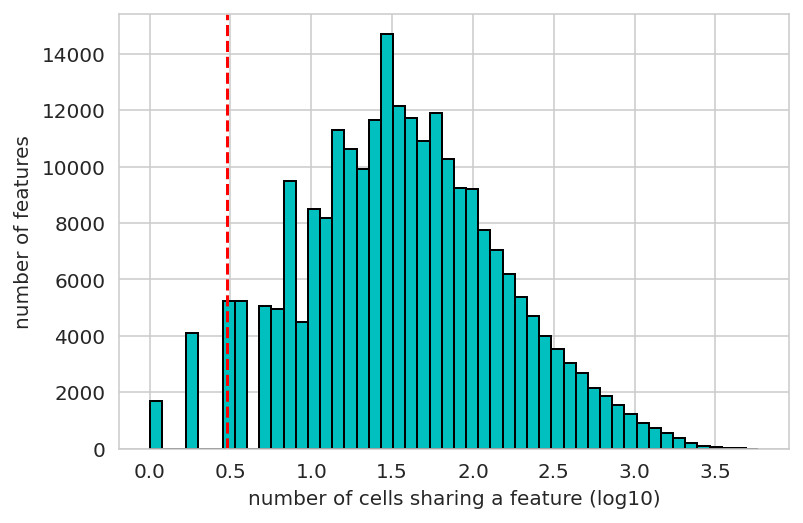

In [50]:
epi.pp.coverage_features(scatac, binary=True, log=False, bins=50, threshold=3)
epi.pp.coverage_features(scatac, binary=True, log=True, bins=50, threshold=3)

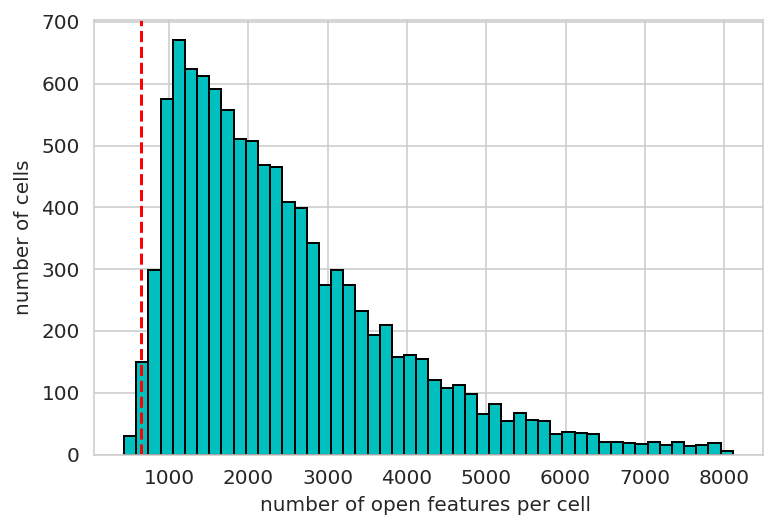

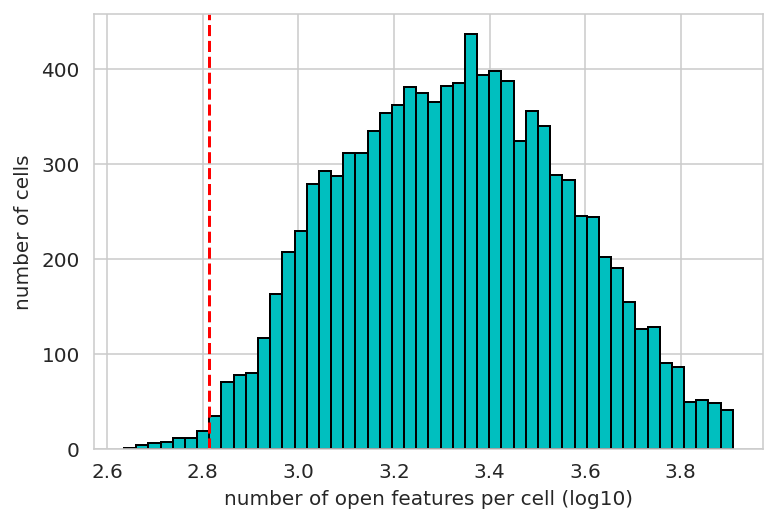

In [54]:
epi.pp.coverage_cells(scatac, binary=True, log=False, bins=50, threshold=650)
epi.pp.coverage_cells(scatac, binary=True, log=True, bins=50, threshold=650)

## Filter low quality cells and peaks

In [55]:
epi.pp.filter_cells(scatac, min_features=650)
epi.pp.filter_features(scatac, min_cells=3)
scatac

AnnData object with n_obs × n_vars = 10252 × 238693
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'

In [56]:
scatac.obs['nb_features'].describe()

count    10252.000000
mean      2480.427624
std       1391.371473
min        651.000000
25%       1426.000000
50%       2141.000000
75%       3175.000000
max       8110.000000
Name: nb_features, dtype: float64

In [57]:
scatac.var['commonness'].describe()

count    238693.000000
mean        106.630039
std         221.276390
min           3.000000
25%          16.000000
50%          37.000000
75%          97.000000
max        5832.000000
Name: commonness, dtype: float64

In [58]:
scatac.var['commonness'].median()

37.0

In [59]:
scatac = scatac[:, scatac.var['commonness'] > 37]
scatac

View of AnnData object with n_obs × n_vars = 10252 × 119069
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness'

## Selecting variable peaks

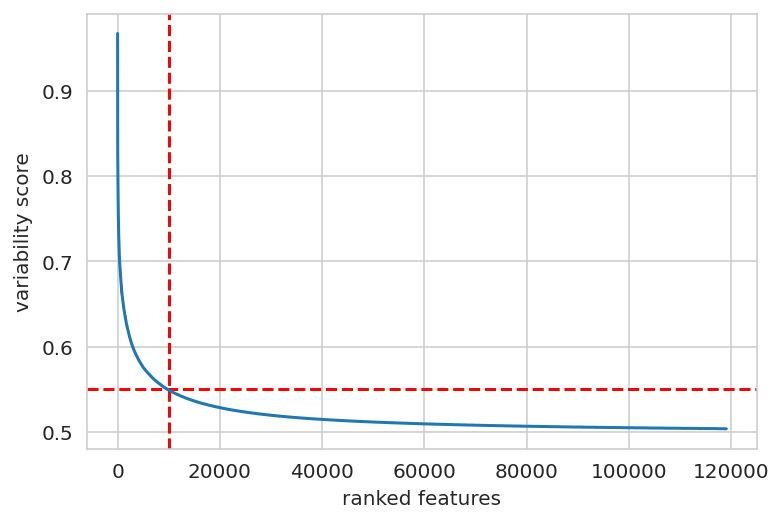

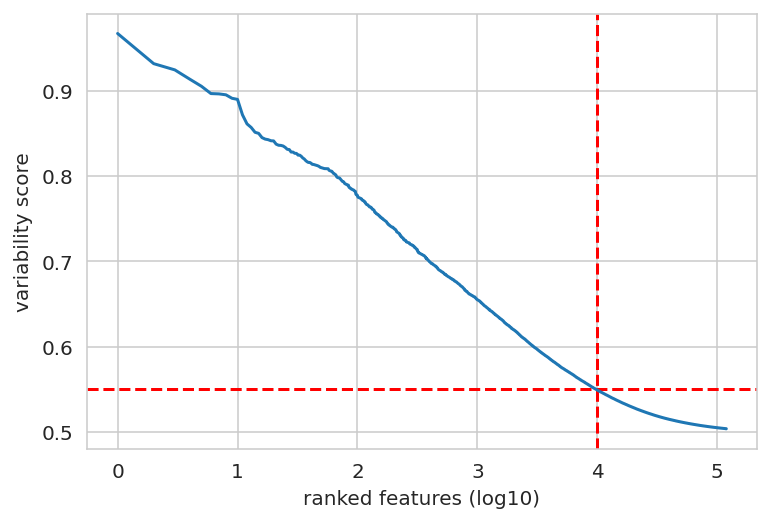

In [61]:
min_score_value = 0.55
nb_feature_selected = 10000
epi.pl.variability_features(scatac, log=None, min_score=min_score_value, nb_features=nb_feature_selected)
epi.pl.variability_features(scatac, log='log10', min_score=min_score_value, nb_features=nb_feature_selected)

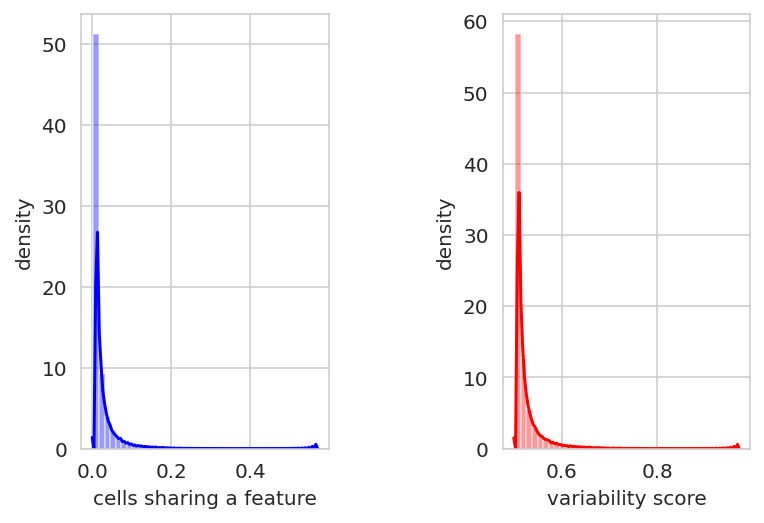

CPU times: user 1.44 s, sys: 108 ms, total: 1.55 s
Wall time: 1.54 s


In [62]:
%time scatac = epi.pp.select_var_feature(scatac, nb_features=nb_feature_selected, copy=True)

In [63]:
scatac

View of AnnData object with n_obs × n_vars = 10252 × 10009
    obs: 'Batch', 'Barcode', 'cell_type', 'nb_features'
    var: 'gene_ids', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

## Visualization

### Running UMAP

In [66]:
sc.pp.neighbors(scatac, random_state=42)
sc.tl.umap(scatac, min_dist=0.1, random_state=42)

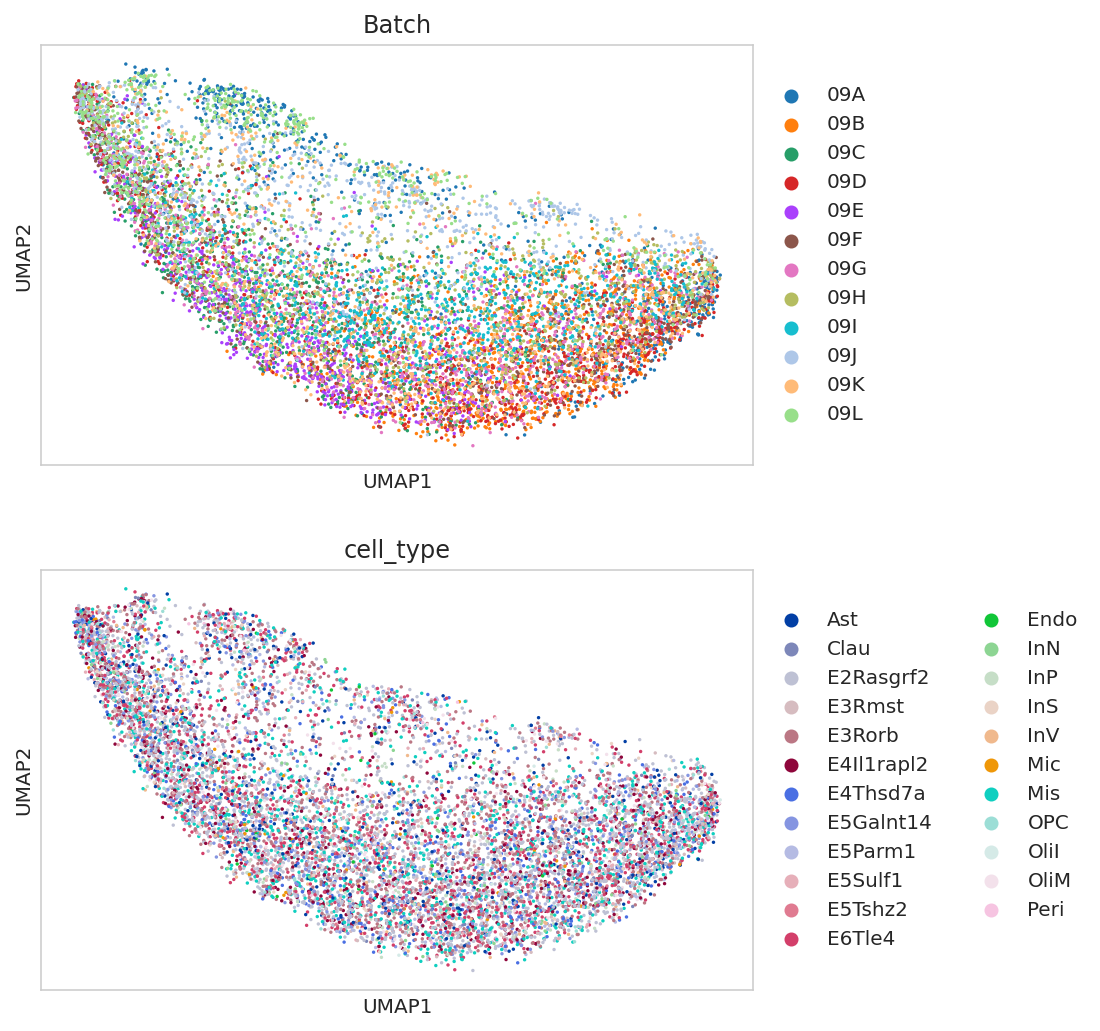

In [67]:
sc.pl.umap(scatac, color=['Batch', 'cell_type'], ncols=1)

---
# Save the results

### Find common paired samples

In [68]:
com_index = set(scrna.obs.index) & set(scatac.obs.index)
scrna = scrna[scrna.obs.index.isin(com_index)]
scatac = scatac[scatac.obs.index.isin(com_index)]
print(scrna.shape, scatac.shape)

(10143, 2695) (10143, 10009)


In [69]:
%time scrna.write(SCRNA_DIR + 'expressions.h5ad')

CPU times: user 128 ms, sys: 32 ms, total: 160 ms
Wall time: 158 ms


In [70]:
%time scatac.write_h5ad(SCATAC_DIR + 'peaks-binary.h5ad')

CPU times: user 296 ms, sys: 108 ms, total: 404 ms
Wall time: 581 ms
